## Imports and Parameter Initialization

In [98]:
import numpy as np
import sys
sys.path.append('../../..')

from src.dataset.dataset_configurations import (
    ClassConfig, DatasetConfig, IMMSpec, SegmentSpec,
    CVSpec, CASpec, CTSpec, ParamRange
)
from src.imm_models.models_for_imm import (
    IMMConstantVelocityKF, IMMConstantAccelerationKF, IMMCoordinatedTurnKF,
    InitializationData, STATE_DIM_2D
)
from filterpy.kalman import IMMEstimator

from src.dataset.random_gen import random_generator
import numpy as np

%load_ext autoreload
%autoreload 2


The autoreload extension is already loaded. To reload it, use:
  %reload_ext autoreload


In [99]:
measurement_noise_std=np.array([0.4, 0.4])
dim = 2
dt = 0.04
rng = random_generator.get_rng()
n_trajectories = 100 # per class

In [100]:
# Class 1: Highly Maneuvering Target with Sharp Turns
uav_high_maneuver = ClassConfig(
    name="HighlyManeuveringTargetSharpTurns",
    model_spec=IMMSpec(
        segments=[
            # Sharp CT turn
            SegmentSpec(
                model_spec=CTSpec(
                    #omega=rng.uniform(0.5, 1.5),  # High turn rate: 28-86 degrees/sec
                    #omega_noise_std=rng.uniform(0.05, 0.3),  # Turn rate variability
                    omega=1.2,
                    omega_noise_std=0.2,
                    measurement_noise_std=measurement_noise_std
                ),
                T=100
            ),
            # Rapid acceleration
            SegmentSpec(
                model_spec=CASpec(
                    #accel_noise_std=rng.uniform(0.3, 0.5, size=dim),  # High acceleration variability
                    #acceleration=rng.uniform(-3.0, 3.0, size=dim),  # ±3 m/s² (aggressive)
                    acceleration=np.array([2, 2]),
                    accel_noise_std=np.array([0.4, 0.4]),
                    measurement_noise_std=measurement_noise_std
                ),
                T=50
            ),
            # Brief steady flight
            SegmentSpec(
                model_spec=CVSpec(
                    #vel_change_std=rng.uniform(0.4, 0.6, size=dim),  # High process noise
                    vel_change_std=np.array([0.5,0.5]),
                    measurement_noise_std=measurement_noise_std
                ),
                T=50
            ),
            # Another sharp turn (opposite direction)
            SegmentSpec(
                model_spec=CTSpec(
                    #omega=rng.uniform(-1.5, -0.5),  # Negative omega (opposite turn)
                    #omega_noise_std=rng.uniform(0.05, 0.3),
                    omega=-1.2,
                    omega_noise_std=0.2,
                    measurement_noise_std=measurement_noise_std
                ),
                T=100
            ),
        ],
        randomize_blueprint=True,  # Unpredictable maneuver sequences
        min_segment_length=15,
        max_segment_length=35,
        measurement_noise_std=np.array([0.5, 0.5])  # Required by ModelSpec base class
    ),
    n_trajectories=n_trajectories
)

print("Highly Maneuvering Target (Sharp Turns) class configured")
print(f"  - {len(uav_high_maneuver.model_spec.segments)} segment blueprints")
print(f"  - Blueprint randomization: {uav_high_maneuver.model_spec.randomize_blueprint}")
print(f"  - Segment length range: {uav_high_maneuver.model_spec.min_segment_length}-{uav_high_maneuver.model_spec.max_segment_length}")

Highly Maneuvering Target (Sharp Turns) class configured
  - 4 segment blueprints
  - Blueprint randomization: True
  - Segment length range: 15-35


In [88]:
# Class 2: Moderate Maneuvering Target With Turns
uav_moderate_maneuver = ClassConfig(
    name="ModerateManeuveringTargetWithTurns",
    model_spec=IMMSpec(
        segments=[
            # Long steady cruise
            SegmentSpec(
                model_spec=CVSpec(
                    #vel_change_std=rng.uniform(0.1, 0.15, size=dim),  # Low process noise
                    vel_change_std=np.array([0.125, 0.125]),
                    measurement_noise_std=measurement_noise_std
                ),
                T=100
            ),
            # Gentle turn
            SegmentSpec(
                model_spec=CTSpec(
                    #omega=rng.uniform(0.1, 0.3),  # Low turn rate: 6-17 degrees/sec
                    omega=0.2,
                    #omega_noise_std=rng.uniform(0.01, 0.03),  # Stable turn control
                    omega_noise_std=0.02,
                    measurement_noise_std=measurement_noise_std
                ),
                T=50
            ),
            # Mild acceleration (speed adjustment)
            SegmentSpec(
                model_spec=CASpec(
                    #accel_noise_std=rng.uniform(0.08, 0.12, size=dim),  # Low variability
                    accel_noise_std=np.array([0.1, 0.1]),
                    #acceleration=rng.uniform(-0.5, 0.5, size=dim),  # Gentle: ±0.5 m/s²
                    acceleration=np.array([0.0, 0.0]),
                    measurement_noise_std=measurement_noise_std
                ),
                T=50
            ),
            # Return to steady cruise
            SegmentSpec(
                model_spec=CVSpec(
                    #vel_change_std=rng.uniform(0.1, 0.15, size=dim),
                    vel_change_std=np.array([0.125, 0.125]),
                    measurement_noise_std=measurement_noise_std
                ),
                T=100
            ),
        ],
        randomize_order=False,  # Predictable flight pattern
        randomize_blueprint=False,
        measurement_noise_std=measurement_noise_std
    ),
    n_trajectories=n_trajectories
)

print("Moderate Maneuvering Target with Turns class configured")
print(f"  - {len(uav_moderate_maneuver.model_spec.segments)} sequential segments")
print(f"  - Randomization: None (predictable patterns)")
print(f"  - Total trajectory length: {sum(s.T for s in uav_moderate_maneuver.model_spec.segments)} steps")


Moderate Maneuvering Target with Turns class configured
  - 4 sequential segments
  - Randomization: None (predictable patterns)
  - Total trajectory length: 300 steps


In [101]:
# Class 3: Agile Target with Erratic Turns and Bursts
bird_high_maneuver = ClassConfig(
    name="AgileTargetErraticTurnsAndBursts",
    model_spec=IMMSpec(
        segments=[
            # Banking turn (pursuit)
            SegmentSpec(
                model_spec=CTSpec(
                    #omega=rng.uniform(0.6, 1.4),  # 34-69 degrees/sec (agile turn)
                    omega=1.0,
                    #omega_noise_std=rng.uniform(0.08, 0.15),  # Wing-flapping variability
                    omega_noise_std=0.12,
                    measurement_noise_std=measurement_noise_std  # Smaller target
                ),
                T=40
            ),
            # Diving acceleration (attack)
            SegmentSpec(
                model_spec=CASpec(
                    #accel_noise_std=rng.uniform(0.4, 0.6, size=dim),  # High biological variability
                    accel_noise_std=np.array([0.5, 0.5]),
                    #acceleration=rng.uniform(-4.0, -1.0, size=dim),  # Diving: -1 to -4 m/s²
                    acceleration=np.array([-2.5, -2.5]),
                    measurement_noise_std=measurement_noise_std
                ),
                T=20
            ),
            # Rapid climb (escape)
            SegmentSpec(
                model_spec=CASpec(
                    #accel_noise_std=rng.uniform(0.4, 0.6, size=dim),
                    accel_noise_std=np.array([0.5, 0.5]),
                    #acceleration=rng.uniform(1.5, 4.0, size=dim),  # Climbing: +1.5 to +4 m/s²
                    acceleration=np.array([2.5, 2.5]),
                    measurement_noise_std=measurement_noise_std
                ),
                T=100
            ),
            # Brief gliding
            SegmentSpec(
                model_spec=CVSpec(
                    #vel_change_std=rng.uniform(0.5, 0.8, size=dim),  # High flapping noise
                    vel_change_std=np.array([0.65, 0.65]),
                    measurement_noise_std=measurement_noise_std
                ),
                T=60
            ),
            # Another banking turn
            SegmentSpec(
                model_spec=CTSpec(
                    #omega=rng.uniform(-1.2, -0.6),  # Opposite direction turn
                    omega=-0.9,
                    #omega_noise_std=rng.uniform(0.08, 0.15),
                    omega_noise_std=0.12,
                    measurement_noise_std=measurement_noise_std
                ),
                T=80
            ),
        ],
        randomize_order=True,  # Erratic, unpredictable flight
        randomize_blueprint=False,
        measurement_noise_std=measurement_noise_std
    ),
    n_trajectories=n_trajectories
)

print("Random Segments of Sharp Motions class configured")
print(f"  - {len(bird_high_maneuver.model_spec.segments)} segment types")
print(f"  - Order randomization: {bird_high_maneuver.model_spec.randomize_order}")
print(f"  - Includes diving and climbing CA segments")


Random Segments of Sharp Motions class configured
  - 5 segment types
  - Order randomization: True
  - Includes diving and climbing CA segments


In [102]:
# Class 4: Gliding Target with Gentle Turns
bird_moderate_maneuver = ClassConfig(
    name="GlidingTargetGentleTurns",
    model_spec=IMMSpec(
        segments=[
            # Long gliding phase
            SegmentSpec(
                model_spec=CVSpec(
                    #vel_change_std=rng.uniform(0.18, 0.22, size=dim),  # Moderate flapping noise
                    vel_change_std=np.array([0.20, 0.20]),
                    measurement_noise_std=measurement_noise_std
                ),
                T=150
            ),
            # Gentle banking turn
            SegmentSpec(
                model_spec=CTSpec(
                    #omega=rng.uniform(0.15, 0.35),  # 9-20 degrees/sec
                    omega=0.25,
                    omega_noise_std=0.03,  # Low turn variability
                    measurement_noise_std=measurement_noise_std
                ),
                T=50
            ),
            # Mild altitude change
            SegmentSpec(
                model_spec=CASpec(
                    #accel_noise_std=rng.uniform(0.10, 0.14, size=dim),  # Low acceleration noise
                    accel_noise_std=np.array([0.12, 0.12]),
                    #acceleration=rng.uniform(-0.8, 0.8, size=dim),  # Gentle: ±0.8 m/s²
                    acceleration=np.array([1.0, 1.0]),
                    measurement_noise_std=measurement_noise_std
                ),
                T=40
            ),
            # Return to gliding
            SegmentSpec(
                model_spec=CVSpec(
                    #vel_change_std=rng.uniform(0.2, 0.22, size=dim),
                    vel_change_std=np.array([0.2, 0.2]),
                    measurement_noise_std=measurement_noise_std
                ),
                T=60
            ),
        ],
        randomize_order=False,  # Predictable patterns
        randomize_blueprint=False,
        measurement_noise_std=measurement_noise_std
    ),
    n_trajectories=n_trajectories
)

print("Gliding Target with Gentle Turns class configured")
print(f"  - {len(bird_moderate_maneuver.model_spec.segments)} sequential segments")
print(f"  - Dominated by CV gliding ({sum(s.T for s in bird_moderate_maneuver.model_spec.segments if isinstance(s.model_spec, CVSpec))} steps)")
print(f"  - No randomization (predictable patterns)")


Gliding Target with Gentle Turns class configured
  - 4 sequential segments
  - Dominated by CV gliding (210 steps)
  - No randomization (predictable patterns)


In [103]:
# Class 5: Extreme Maneuvering Target with Rapid Mode Switching
generic_extreme_maneuver = ClassConfig(
    name="ExtremeManeuveringTargetRapidModeSwitching",
    model_spec=IMMSpec(
        segments=[
            # Extreme turn #1
            SegmentSpec(
                model_spec=CTSpec(
                    #omega=rng.uniform(1.0, 2.0),  # Very high: 57-115 degrees/sec
                    omega=2.0,
                    #omega_noise_std=rng.uniform(0.1, 0.2),  # High variability
                    omega_noise_std=0.15,
                    measurement_noise_std=measurement_noise_std
                ),
                T=60
            ),
            # Extreme acceleration
            SegmentSpec(
                model_spec=CASpec(
                    #accel_noise_std=rng.uniform(0.6, 0.9, size=dim),  # Very high noise
                    accel_noise_std=np.array([0.75, 0.75]),
                    #acceleration=rng.uniform(-5.0, 5.0, size=dim),  # Extreme: ±5 m/s²
                    acceleration=np.array([4.0, 4.0]),
                    measurement_noise_std=measurement_noise_std
                ),
                T=60
            ),
            # Chaotic constant velocity
            SegmentSpec(
                model_spec=CVSpec(
                    #vel_change_std=rng.uniform(0.7, 1.0, size=dim),
                    vel_change_std=np.array([0.85, 0.85]),
                    measurement_noise_std=measurement_noise_std
                ),
                T=60
            ),
            # Extreme turn #2 (opposite direction)
            SegmentSpec(
                model_spec=CTSpec(
                    #omega=rng.uniform(-2.0, -1.0),  # Opposite direction
                    omega=-1.5,
                    #omega_noise_std=rng.uniform(0.1, 0.2),
                    omega_noise_std=0.15,
                    measurement_noise_std=measurement_noise_std
                ),
                T=60
            ),
            # Rapid deceleration
            SegmentSpec(
                model_spec=CASpec(
                    #accel_noise_std=rng.uniform(0.6, 0.9, size=dim),
                    accel_noise_std=np.array([0.75, 0.75]),
                    #acceleration=rng.uniform(-6.0, -2.0, size=dim),  # Strong braking
                    acceleration=np.array([-4.0, -4.0]),
                    measurement_noise_std=measurement_noise_std
                ),
                T=60
            ),
            # Brief CV before next maneuver
            SegmentSpec(
                model_spec=CVSpec(
                    #vel_change_std=rng.uniform(0.7, 1.0, size=dim),
                    vel_change_std=np.array([0.85, 0.85]),
                    measurement_noise_std=measurement_noise_std
                ),
                T=60
            ),
        ],
        randomize_blueprint=True,  # Maximum unpredictability
        min_segment_length=10,  # Very short segments
        max_segment_length=25,  # Frequent mode changes
        measurement_noise_std=measurement_noise_std
    ),
    n_trajectories=n_trajectories
)

print("Extreme Maneuvering Target with Rapid Mode Switching class configured")
print(f"  - {len(generic_extreme_maneuver.model_spec.segments)} segment blueprints")
print(f"  - Blueprint randomization: {generic_extreme_maneuver.model_spec.randomize_blueprint}")
print(f"  - Very short segments ({generic_extreme_maneuver.model_spec.min_segment_length}-{generic_extreme_maneuver.model_spec.max_segment_length} steps) for rapid mode switching")
print(f"  - Maximum noise levels (σ_v up to 1.0, σ_meas = 0.9)")


Extreme Maneuvering Target with Rapid Mode Switching class configured
  - 6 segment blueprints
  - Blueprint randomization: True
  - Very short segments (10-25 steps) for rapid mode switching
  - Maximum noise levels (σ_v up to 1.0, σ_meas = 0.9)



## Summary of All Classes


In [104]:
import pandas as pd

# Summary comparison
classes = [
    uav_high_maneuver,
    uav_moderate_maneuver,
    bird_high_maneuver,
    bird_moderate_maneuver,
    generic_extreme_maneuver
]

summary_data = []
for cls in classes:
    spec = cls.model_spec
    model_types = [type(s.model_spec).__name__ for s in spec.segments]
    model_counts = f"CV:{model_types.count('CVSpec')}, CA:{model_types.count('CASpec')}, CT:{model_types.count('CTSpec')}"
    
    summary_data.append({
        'Class': cls.name,
        'Segments': len(spec.segments),
        'Models': model_counts,
        'Randomize Order': spec.randomize_order,
        'Randomize Blueprint': spec.randomize_blueprint,
        'N Trajectories': cls.n_trajectories
    })

df_summary = pd.DataFrame(summary_data)
print("\n=== Motion Model Classes Summary ===")
print(df_summary.to_string(index=False))


=== Motion Model Classes Summary ===
                                     Class  Segments           Models  Randomize Order  Randomize Blueprint  N Trajectories
         HighlyManeuveringTargetSharpTurns         4 CV:1, CA:1, CT:2            False                 True             100
        ModerateManeuveringTargetWithTurns         4 CV:2, CA:1, CT:1            False                False             100
          AgileTargetErraticTurnsAndBursts         5 CV:1, CA:2, CT:2             True                False             100
                  GlidingTargetGentleTurns         4 CV:2, CA:1, CT:1            False                False             100
ExtremeManeuveringTargetRapidModeSwitching         6 CV:2, CA:2, CT:2            False                 True             100



## Create Dataset Configuration


In [105]:
# Create a dataset config with all 5 classes
dataset_config = DatasetConfig(
    seed=43,
    dim=dim,
    dt=dt,
    T=300,  # Target trajectory length for blueprint mode
    init_pos_range=(-50.0, 50.0),
    init_speed_range=(-20, 20.0),  # Reasonable flight speeds
    classes=[
        uav_high_maneuver,
        uav_moderate_maneuver,
        bird_high_maneuver,
        bird_moderate_maneuver,
        generic_extreme_maneuver
    ],
    store_clean=True,
)

print("Dataset Configuration:")
for cls in dataset_config.classes:
    print(f"  - {cls.name}: {cls.n_trajectories} trajectories")


Dataset Configuration:
  - HighlyManeuveringTargetSharpTurns: 100 trajectories
  - ModerateManeuveringTargetWithTurns: 100 trajectories
  - AgileTargetErraticTurnsAndBursts: 100 trajectories
  - GlidingTargetGentleTurns: 100 trajectories
  - ExtremeManeuveringTargetRapidModeSwitching: 100 trajectories


---

# Full Dataset Generation

Generate the complete dataset with all trajectories for all classes:


In [106]:
from src.dataset.dataset_configurations import generate_dataset
import time

random_generator.reinitialize()
# Generate the full dataset
full_data = generate_dataset(dataset_config)
print(f"Dataset generation completed")


Final state: TrajectoryState(position=array([-17.31235504, -48.48651676]), velocity=array([10.954198  , -4.35777022]), acceleration=None, omega=None, tau=None)
Final state: TrajectoryState(position=array([ -9.93529051, -48.81704143]), velocity=array([11.09669063,  3.98096373]), acceleration=None, omega=np.float64(1.1749761844334772), tau=None)
Final state: TrajectoryState(position=array([ -1.25247246, -49.20207304]), velocity=array([10.29175177, -5.75017049]), acceleration=None, omega=np.float64(-1.401837443821483), tau=None)
Final state: TrajectoryState(position=array([  3.28111961, -60.89722588]), velocity=array([ -3.78722331, -11.16429822]), acceleration=None, omega=np.float64(-0.9221913301322788), tau=None)
Final state: TrajectoryState(position=array([  0.6969803 , -72.29219655]), velocity=array([-0.45591835, -9.0958122 ]), acceleration=array([ 3.04567378, -0.25885738]), omega=None, tau=None)
Final state: TrajectoryState(position=array([ -4.60950995, -79.41549967]), velocity=array(

In [107]:
# Find the shortest trajectory and cut all trajectories to its lenght - It will simplify the prediction later.
current_shortest = 1e6

for class_name, class_data in full_data.items():
    if class_name == "config":
        continue
    for trajectory in class_data["X"]:
        if trajectory.shape[0] < current_shortest:
            current_shortest = trajectory.shape[0]
        
T = current_shortest
print(f"Using {T} timestep-trajectories")

# Actually truncate all trajectories to length T (cutting from the end)
print(f"\nTruncating all trajectories to {T} timesteps...")
for class_name, class_data in full_data.items():
    if class_name == "config":
        continue
    
    # Truncate X trajectories (measurements)
    truncated_count = 0
    for i, trajectory in enumerate(class_data["X"]):
        if trajectory.shape[0] > T:
            class_data["X"][i] = trajectory[:T]  # Keep first T timesteps, cut from end
            truncated_count += 1
    
    # Truncate Y trajectories (clean trajectories) if they exist
    if "Y" in class_data and class_data["Y"] is not None:
        for i, trajectory in enumerate(class_data["Y"]):
            if trajectory.shape[0] > T:
                class_data["Y"][i] = trajectory[:T]  # Keep first T timesteps, cut from end

print("Trajectory truncation complete")



Using 280 timestep-trajectories

Truncating all trajectories to 280 timesteps...
Trajectory truncation complete


# IMM Tracking Evaluation

This section evaluates the tracking performance of each IMM filter on trajectories from its corresponding class. We will:

1. Run each IMM on sample trajectories from its class
2. Calculate MSE between IMM predictions and actual measurements
3. Track model probability evolution to understand mode switching
4. Visualize tracking performance with prediction overlays

The evaluation uses **1-step ahead prediction** (k=1) to assess real-time tracking capability.


In [108]:
# Organize class configs and IMMs for evaluation
# Collect all class configs into a list
class_configs = [
    uav_high_maneuver,
    uav_moderate_maneuver,
    bird_high_maneuver,
    bird_moderate_maneuver,
    generic_extreme_maneuver
]

# Extract class names
class_names = full_data.keys()


In [109]:
# Import IMM K-Lag Evaluator
from src.imm_models.imm_k_lag import IMMKlagEvaluator
import matplotlib.pyplot as plt

# Evaluation configuration
k = 5  # k-step ahead prediction


In [110]:
def calculate_k_step_ahead_variance(k:int, trajectory: np.ndarray):
    """
    We calculate a naive prediction method - predict the next coordinate to be the same as the current one.
    :param k: 
    :param trajectory: 
    :return: MSE
    """
    # Current measurements (predictions): z_0, z_1, ..., z_{T-1}
    predictions = trajectory[:-k]
    
    # Next measurements (targets): z_1, z_2, ..., z_T
    targets = trajectory[k:]
        
    # Calculate MSE: mean((targets - predictions)^2)
    mse = np.mean((targets - predictions) ** 2)  # Shape: (T-k, 2)
    return mse


In [111]:
# Run IMM evaluation on each class

# Storage for results
kf_predictions_per_trajectory = {class_name : {} for class_name in list(full_data.keys())}
kf_mse_per_trajectory = {class_name : {} for class_name in list(full_data.keys())}


for class_name, class_config in zip(class_names, class_configs):
    print(f"\n{'='*80}")
    print(f"Evaluating Class: {class_name}")
    print(f"{'='*80}")
    
    # Get trajectories for this class from full_data
    class_data = full_data[class_name]

    
    n_to_eval = len(class_data["X"])    
    for traj_idx in range(n_to_eval):
        # Get trajectory data
        measurements = class_data["X"][traj_idx]
        
        # Create a new IMM for this trajectory (complete reinitialization)
        imm = class_config.model_spec.create_imm(dt, dim)
        
        # Initialize IMM filters' state and covariance from first measurement and metadata
        meta_entry = class_data["meta"][traj_idx]
        init_velocity = np.array(meta_entry["initial_state"]["velocity"], dtype=float)
        init_position = measurements[0].astype(float)
        
        # Unified 7D state: [x, vx, ax, y, vy, ay, omega]
        x0 = np.array([
            init_position[0], init_velocity[0], 0.0,
            init_position[1], init_velocity[1], 0.0,
            0.0
        ], dtype=float).reshape(-1, 1)
        P0 = np.eye(7, dtype=float) * 10.0
        for kf in imm.filters:
            kf.initialize(x0=x0.copy(), P0=P0.copy())
        
        # Run K-Lag evaluation
        imm_k_lag_eval = IMMKlagEvaluator(imm)
        _, preds_imm = imm_k_lag_eval.run_k_lag(
            measurements=measurements,
            k=k,
            clean_signal=None,  # Compare against noisy measurements
            normalize_mse=False
        )
        
        # Calculate normalized MSE (divide by second moment of measurements)
        target_measurements = measurements[k:]
        #measurement_second_moment = np.mean((target_measurements - target_measurements.mean(axis=0, keepdims=True)) ** 2)
        mse_imm = np.mean((target_measurements - preds_imm)**2)
        nmse_imm = mse_imm / calculate_k_step_ahead_variance(k, measurements)
        
        kf_mse_per_trajectory[class_name][traj_idx] = nmse_imm
        kf_predictions_per_trajectory[class_name][traj_idx] = preds_imm
    
        print(f"Trajectory {traj_idx+1}/{n_to_eval}: NMSE = {nmse_imm:.6f}")
    



Evaluating Class: HighlyManeuveringTargetSharpTurns
Trajectory 1/100: NMSE = 0.213948
Trajectory 2/100: NMSE = 0.130451
Trajectory 3/100: NMSE = 0.101753
Trajectory 4/100: NMSE = 0.297454
Trajectory 5/100: NMSE = 0.052918
Trajectory 6/100: NMSE = 0.257439
Trajectory 7/100: NMSE = 0.220598
Trajectory 8/100: NMSE = 0.101692
Trajectory 9/100: NMSE = 0.093082
Trajectory 10/100: NMSE = 0.183846
Trajectory 11/100: NMSE = 0.093910
Trajectory 12/100: NMSE = 0.197523
Trajectory 13/100: NMSE = 0.059805
Trajectory 14/100: NMSE = 0.366458
Trajectory 15/100: NMSE = 0.134540
Trajectory 16/100: NMSE = 0.186911
Trajectory 17/100: NMSE = 0.124089
Trajectory 18/100: NMSE = 0.114562
Trajectory 19/100: NMSE = 0.078231
Trajectory 20/100: NMSE = 0.159525
Trajectory 21/100: NMSE = 0.353429
Trajectory 22/100: NMSE = 0.096111
Trajectory 23/100: NMSE = 0.349015
Trajectory 24/100: NMSE = 0.044906
Trajectory 25/100: NMSE = 0.148136
Trajectory 26/100: NMSE = 0.381578
Trajectory 27/100: NMSE = 0.091336
Trajectory 

## Comparison: MSE Across All Classes


KeyError: 'X'

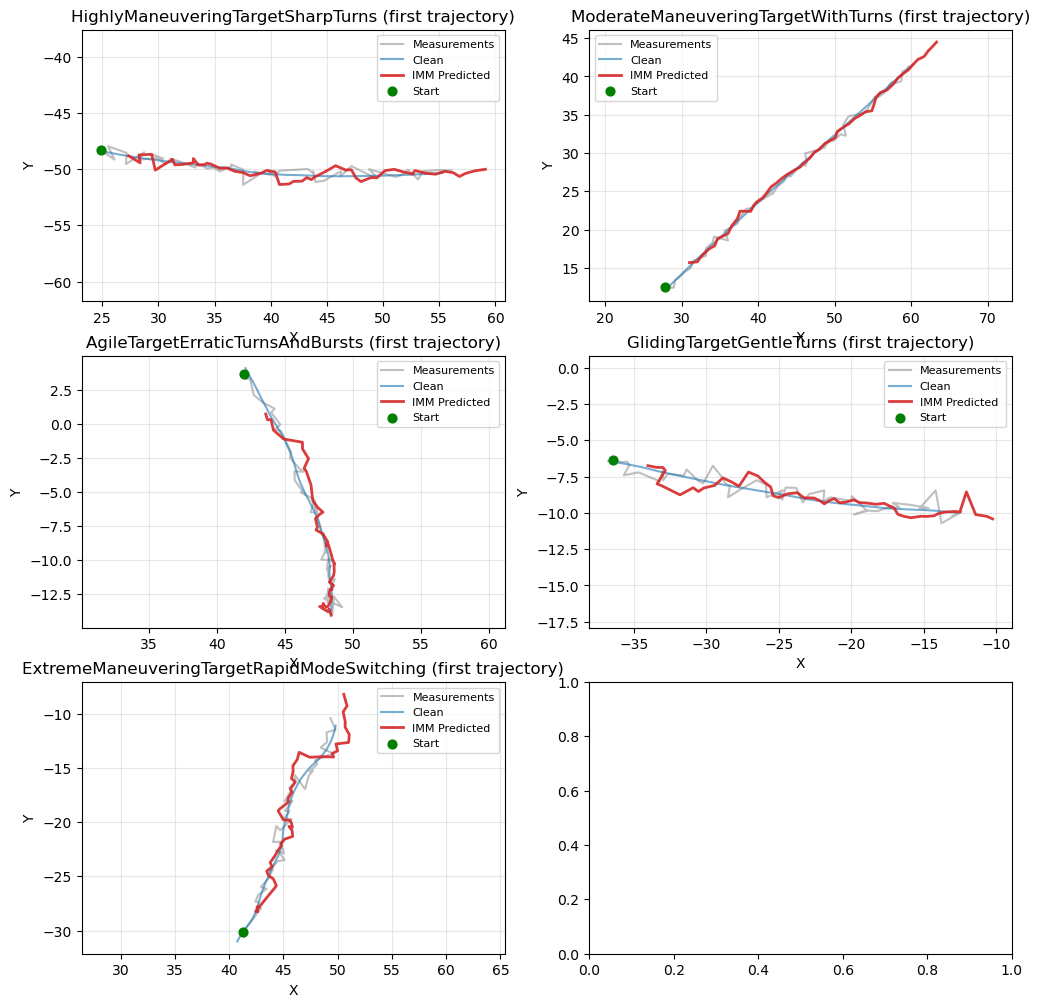

In [112]:
# Plot first trajectory and IMM predicted trajectory for each class
import matplotlib.pyplot as plt
import numpy as np

classes = class_names  # already defined earlier
num_classes = len(classes)
cols = 2 if num_classes > 1 else 1
rows = int(np.ceil(num_classes / cols))
index=7
fig, axes = plt.subplots(rows, cols, figsize=(12, 4*rows))
axes = np.array(axes).reshape(-1) if num_classes > 1 else np.array([axes])

k = k if 'k_lag' in globals() else 1

for i, class_name in enumerate(classes):
    ax = axes[i]
    class_data = full_data[class_name]
    measurements = class_data['X'][index][:50]
    clean = class_data['Y'][index][:50] if class_data['Y'][:50] is not None else None
    preds = kf_predictions_per_trajectory[class_name][index][:50]

    # Plot measured trajectory
    ax.plot(measurements[:, 0], measurements[:, 1], color='gray', alpha=0.5, linewidth=1.5, label='Measurements')
    if clean is not None:
        ax.plot(clean[:, 0], clean[:, 1], color='tab:blue', alpha=0.6, linewidth=1.5, label='Clean')

    # Plot predicted trajectory (aligned from t=k onward)
    ax.plot(preds[:, 0], preds[:, 1], color='tab:red', alpha=0.9, linewidth=2, label='IMM Predicted')

    # Start marker
    ax.scatter(measurements[0, 0], measurements[0, 1], c='green', s=40, zorder=5, label='Start')

    ax.set_title(f"{class_name} (first trajectory)")
    ax.set_xlabel('X')
    ax.set_ylabel('Y')
    ax.axis('equal')
    ax.grid(True, alpha=0.3)
    ax.legend(loc='best', fontsize=8)

# Hide any unused subplots
for j in range(i+1, len(axes)):
    fig.delaxes(axes[j])

plt.tight_layout()
plt.show()


---

# Chronos-2 Batched K-Lag Prediction

We now run k-lag prediction using Chronos-2 in a batched, rolling fashion (mirroring the setup in `simple_experiment/imm_run.ipynb`).

- Input to Chronos: noisy observations (same as IMM measurement space)
- Output: k-step-ahead predictions aligned to compare with the appropriate measurements
- Batching: across trajectories at each rolling step



In [113]:
# Load Chronos-2 pipeline (same approach as in simple_experiment/imm_run.ipynb)
import torch
import numpy as np
from typing import List
import torch
from chronos import BaseChronosPipeline, Chronos2Pipeline, ChronosPipeline
import os


print("="*60)
print("CUDA INFORMATION")
print("="*60)
print(f"CUDA Available: {torch.cuda.is_available()}")
print(f"CUDA Version: {torch.version.cuda if torch.cuda.is_available() else 'N/A'}")
if torch.cuda.is_available():
    print(f"Number of GPUs: {torch.cuda.device_count()}")
    for i in range(torch.cuda.device_count()):
        print(f"  GPU {i}: {torch.cuda.get_device_name(i)}")
        print(f"    Memory Allocated: {torch.cuda.memory_allocated(i) / 1024**3:.2f} GB")
        print(f"    Memory Cached: {torch.cuda.memory_reserved(i) / 1024**3:.2f} GB")
print("="*60)

# Set GPU if available (use GPU 0 by default, which is most common)
if torch.cuda.is_available():
    os.environ["CUDA_VISIBLE_DEVICES"] = "0"
    device = "cuda:0"
else:
    device = "cpu"
    print("WARNING: CUDA not available, using CPU. Inference will be slower.")

# Load the Chronos-2 pipeline
print(f"\nLoading Chronos-2 pipeline on {device}...")
pipeline: ChronosPipeline = BaseChronosPipeline.from_pretrained(
    "amazon/chronos-2", 
    device_map=device,
    torch_dtype=torch.float16 if torch.cuda.is_available() else torch.float32  # Use FP16 on GPU for speed
)

print(f"✓ Chronos-2 pipeline loaded successfully on {device}!")

# Verify model is on correct device
if hasattr(pipeline, 'model'):
    model_device = next(pipeline.model.parameters()).device
    print(f"Model device: {model_device}")



CUDA INFORMATION
CUDA Available: True
CUDA Version: 12.1
Number of GPUs: 1
  GPU 0: NVIDIA GeForce RTX 2060 with Max-Q Design
    Memory Allocated: 0.23 GB
    Memory Cached: 1.44 GB

Loading Chronos-2 pipeline on cuda:0...
✓ Chronos-2 pipeline loaded successfully on cuda:0!
Model device: cuda:0


In [114]:
## 🎯 OPTIMAL: Multi-Trajectory Rolling Forecast with Batching

# This approach batches ACROSS trajectories while maintaining rolling forecast
import time

initial_context_length = 3  # Minimum context to start predictions

n_predictions = T - initial_context_length - k
# Storage for all predictions
all_predictions = []

start_rolling = time.time()

print(f"K-LAG PREDICTION: k={k}, initial_context={initial_context_length}")
print(f"Will make {n_predictions} predictions from timestep {initial_context_length} to {T - k}")
print("="*80)

predictions_per_class = {
    class_name: [[] for _ in range(n_trajectories)]
    for class_name in full_data.keys()
    if class_name != "config"
}

# Expanding-window k-lag forecast: iterate through timesteps, batch across trajectories
for step in range(initial_context_length, T - k + 1):
    start_step = time.time()
    # Prepare contexts for ALL trajectories at THIS timestep
    contexts_this_step = []
    
    # Set up the trajectories (up until the inference point) in the necessary DF
    for class_name, class_data in full_data.items():
        if class_name == "config":
            continue
        for traj_idx in range(n_trajectories):
            trajectory_data = class_data['X'][traj_idx]
            
            # Context: all data up to current step (expanding window)
            context_data = trajectory_data[:step]
            timestamps = pd.date_range(start='2025-01-01', periods=step, freq='40ms')
            
            df_context = pd.DataFrame({
                'item_id': [f'{class_name}_traj_{traj_idx}'] * step,
                'timestamp': timestamps,
                'x': context_data[:, 0],
                'y': context_data[:, 1]
            })
            
            contexts_this_step.append(df_context)
    
    # Combine all trajectory contexts for this timestep
    combined_contexts = pd.concat(contexts_this_step, ignore_index=True)
    
    # ONE batch prediction for all trajectories at this timestep
    # Predict k steps ahead, but only keep the k'th prediction
    pred_df = pipeline.predict_df(
        combined_contexts,
        prediction_length=k,
        quantile_levels=[],
        id_column='item_id',
        timestamp_column='timestamp',
        target=['x', 'y']
    )
    
    # Extract only the k'th (last) prediction for each trajectory per class
    for class_name in full_data.keys():
        if class_name == "config":
            continue
        
        for traj_idx in range(n_trajectories):
            item_id = f'{class_name}_traj_{traj_idx}'
            
            # Find this trajectory's predictions
            traj_rows = pred_df[pred_df['item_id'] == item_id]
            if len(traj_rows) == 0:
                continue
            
            # Sort by timestamp to get the k'th (last) prediction
            traj_rows_sorted = traj_rows.sort_values('timestamp')
            
            # Extract x and y for the k'th step (last timestamp)
            last_timestamp = traj_rows_sorted['timestamp'].iloc[-1]
            last_preds = traj_rows_sorted[traj_rows_sorted['timestamp'] == last_timestamp]
            
            # Get x and y predictions
            x_pred = last_preds[last_preds['target_name'] == 'x']['predictions'].values[0]
            y_pred = last_preds[last_preds['target_name'] == 'y']['predictions'].values[0]
            
            # Append [x, y] for this step to the trajectory's sequence
            predictions_per_class[class_name][traj_idx].append(np.array([x_pred, y_pred]))
    
    # Progress
    end_step = time.time()
    print(f"Step {step - initial_context_length + 1}/{n_predictions} ::: context_size={step}, predict at t+{k} ::: time: {end_step - start_step:.3f}s")

# Convert accumulated per-trajectory lists to numpy arrays
for class_name in list(predictions_per_class.keys()):
    predictions_per_class[class_name] = [np.array(seq) for seq in predictions_per_class[class_name]]

elapsed_rolling = time.time() - start_rolling

print("Finished prediction")


K-LAG PREDICTION: k=5, initial_context=3
Will make 272 predictions from timestep 3 to 275
Step 1/272 ::: context_size=3, predict at t+5 ::: time: 24.032s
Step 2/272 ::: context_size=4, predict at t+5 ::: time: 14.366s
Step 3/272 ::: context_size=5, predict at t+5 ::: time: 15.473s
Step 4/272 ::: context_size=6, predict at t+5 ::: time: 14.554s
Step 5/272 ::: context_size=7, predict at t+5 ::: time: 14.688s
Step 6/272 ::: context_size=8, predict at t+5 ::: time: 14.751s
Step 7/272 ::: context_size=9, predict at t+5 ::: time: 15.200s
Step 8/272 ::: context_size=10, predict at t+5 ::: time: 15.007s
Step 9/272 ::: context_size=11, predict at t+5 ::: time: 14.688s
Step 10/272 ::: context_size=12, predict at t+5 ::: time: 15.033s
Step 11/272 ::: context_size=13, predict at t+5 ::: time: 14.774s
Step 12/272 ::: context_size=14, predict at t+5 ::: time: 14.617s
Step 13/272 ::: context_size=15, predict at t+5 ::: time: 14.844s
Step 14/272 ::: context_size=16, predict at t+5 ::: time: 14.988s
St

In [115]:
# Calculate Chronos MSE for comparison
chronos_mse_per_trajectory = {class_name : {} for class_name in list(full_data.keys())}
chronos_predictions_per_trajectory = {class_name : {} for class_name in list(full_data.keys())}

print(f"\nCalculating Chronos K-Lag MSE...")
print(f"Note: Both models evaluated on ability to predict k={k} steps ahead")
print(f"      Predictions compared against measurements at time t+{k}")

for class_name in full_data.keys():
    if class_name == "config":
        continue
    for traj_idx in range(n_trajectories):
        # Chronos predictions start at initial_context_length and predict k steps ahead
        # At step=s: context is [0:s] (indices 0 to s-1), predicts k steps ahead → predicts index (s-1) + k = s + k - 1
        # At step=initial_context_length: predicts index initial_context_length + k - 1
        # At step=initial_context_length+i: predicts index initial_context_length + i + k - 1
        # So prediction[i] corresponds to predicting time initial_context_length + i + k - 1
        # We compare prediction[i] with measurement[initial_context_length + i + k - 1]
        
        # Get corresponding measurements (at time t+k-1 for each prediction)
        # Measurements range from [initial_context_length + k - 1] to [T]
        chronos_preds = predictions_per_class[class_name][traj_idx]

        noisy_measurements = full_data[class_name]["X"][traj_idx][initial_context_length - 1 + k:]
        
        # Ensure shapes match
        chronos_preds = chronos_preds
        noisy_measurements = noisy_measurements
        
        # Calculate MSE against actual measurements at t+k
        mse_chronos = ((noisy_measurements - chronos_preds)**2).mean()
        #measurement_second_moment = np.mean((noisy_measurements - noisy_measurements.mean(axis=0, keepdims=True)) ** 2)
        nmse_chronos = mse_chronos / calculate_k_step_ahead_variance(k, noisy_measurements)
        chronos_mse_per_trajectory[class_name][traj_idx] = nmse_chronos
        chronos_predictions_per_trajectory[class_name][traj_idx] = chronos_preds
        
        print(f"Trajectory {traj_idx}: Chronos NMSE = {nmse_chronos:.6f}")



Calculating Chronos K-Lag MSE...
Note: Both models evaluated on ability to predict k=5 steps ahead
      Predictions compared against measurements at time t+5
Trajectory 0: Chronos NMSE = 0.307947
Trajectory 1: Chronos NMSE = 0.182253
Trajectory 2: Chronos NMSE = 0.162458
Trajectory 3: Chronos NMSE = 0.367006
Trajectory 4: Chronos NMSE = 0.085278
Trajectory 5: Chronos NMSE = 0.351561
Trajectory 6: Chronos NMSE = 0.213252
Trajectory 7: Chronos NMSE = 0.145598
Trajectory 8: Chronos NMSE = 0.139559
Trajectory 9: Chronos NMSE = 0.161360
Trajectory 10: Chronos NMSE = 0.101914
Trajectory 11: Chronos NMSE = 0.255421
Trajectory 12: Chronos NMSE = 0.128002
Trajectory 13: Chronos NMSE = 0.443407
Trajectory 14: Chronos NMSE = 0.212802
Trajectory 15: Chronos NMSE = 0.256724
Trajectory 16: Chronos NMSE = 0.227938
Trajectory 17: Chronos NMSE = 0.149029
Trajectory 18: Chronos NMSE = 0.165909
Trajectory 19: Chronos NMSE = 0.218404
Trajectory 20: Chronos NMSE = 0.432613
Trajectory 21: Chronos NMSE = 0

In [116]:
from collections import defaultdict
class_results = {}

for class_name in full_data.keys():
    if class_name == "config":
        continue
    class_results[class_name] = {"kf_mse": kf_mse_per_trajectory[class_name],
                                 "chronos_mse": chronos_mse_per_trajectory[class_name],
                                 "params": full_data[class_name]["meta"]["params"] if 'params' in full_data[class_name]["meta"] else {},
                                 }

# Calculate and display statistics per class
print(f"{'Class':<30} | {'Avg IMM MSE':>12} | {'Avg Chronos':>12} | Trajectory Wins (Chronos vs IMM)")
print("-" * 100)

chronos_wins_by_class = 0
total_classes = len(class_results)

for class_name in sorted(class_results.keys()):
    results = class_results[class_name]
    
    avg_imm = np.mean(np.array(list(results['kf_mse'].values())))
    avg_chronos = np.mean(np.array(list(results['chronos_mse'].values())))
    
    # Count trajectory-by-trajectory wins
    chronos_wins = 0
    imm_wins = 0
    n_trajs = len(results['kf_mse'])
    
    for i in range(n_trajs):
        if results['chronos_mse'][i] < results['kf_mse'][i]:
            chronos_wins += 1
        else:
            imm_wins += 1
    
    # Determine which method won majority in this class
    if chronos_wins > imm_wins:
        chronos_wins_by_class += 1
    
    chronos_win_pct = (chronos_wins / n_trajs) * 100
    
    print(f"{class_name:<30} | "
          f"{avg_imm:12.6f} | {avg_chronos:12.6f} | "
          f"Chronos: {chronos_wins:>2}/{n_trajs:<2} ({chronos_win_pct:5.1f}%) | IMM: {imm_wins:>2}/{n_trajs}")

print("=" * 100)
print(f"\nClass-level summary (by majority wins):")
print(f"  Chronos wins majority in: {chronos_wins_by_class}/{total_classes} classes ({chronos_wins_by_class/total_classes*100:.1f}%)")
print(f"  IMM wins majority in: {total_classes - chronos_wins_by_class}/{total_classes} classes ({(total_classes-chronos_wins_by_class)/total_classes*100:.1f}%)")


Class                          |  Avg IMM MSE |  Avg Chronos | Trajectory Wins (Chronos vs IMM)
----------------------------------------------------------------------------------------------------
AgileTargetErraticTurnsAndBursts |     0.091365 |     0.143934 | Chronos:  1/100 (  1.0%) | IMM: 99/100
ExtremeManeuveringTargetRapidModeSwitching |     0.143193 |     0.212449 | Chronos:  1/100 (  1.0%) | IMM: 99/100
GlidingTargetGentleTurns       |     0.097651 |     0.156544 | Chronos:  0/100 (  0.0%) | IMM: 100/100
HighlyManeuveringTargetSharpTurns |     0.165226 |     0.234219 | Chronos:  4/100 (  4.0%) | IMM: 96/100
ModerateManeuveringTargetWithTurns |     0.087863 |     0.139255 | Chronos:  0/100 (  0.0%) | IMM: 100/100

Class-level summary (by majority wins):
  Chronos wins majority in: 0/5 classes (0.0%)
  IMM wins majority in: 5/5 classes (100.0%)


k = 1
Class                          |  Avg IMM MSE |  Avg Chronos | Trajectory Wins (Chronos vs IMM)
----------------------------------------------------------------------------------------------------
AgileTargetErraticTurnsAndBursts |     0.398778 |     0.865323 | Chronos:  0/100 (  0.0%) | IMM: 100/100
ExtremeManeuveringTargetRapidModeSwitching |     0.473739 |     0.858247 | Chronos:  0/100 (  0.0%) | IMM: 100/100
GlidingTargetGentleTurns       |     0.404903 |     0.646190 | Chronos:  0/100 (  0.0%) | IMM: 100/100
HighlyManeuveringTargetSharpTurns |     0.488470 |     0.852965 | Chronos:  0/100 (  0.0%) | IMM: 100/100
ModerateManeuveringTargetWithTurns |     0.398322 |     0.648714 | Chronos:  0/100 (  0.0%) | IMM: 100/100
====================================================================================================



k=5
Class                          |  Avg IMM MSE |  Avg Chronos | Trajectory Wins (Chronos vs IMM)
----------------------------------------------------------------------------------------------------
AgileTargetErraticTurnsAndBursts |     0.091365 |     0.143934 | Chronos:  1/100 (  1.0%) | IMM: 99/100
ExtremeManeuveringTargetRapidModeSwitching |     0.143193 |     0.212449 | Chronos:  1/100 (  1.0%) | IMM: 99/100
GlidingTargetGentleTurns       |     0.097651 |     0.156544 | Chronos:  0/100 (  0.0%) | IMM: 100/100
HighlyManeuveringTargetSharpTurns |     0.165226 |     0.234219 | Chronos:  4/100 (  4.0%) | IMM: 96/100
ModerateManeuveringTargetWithTurns |     0.087863 |     0.139255 | Chronos:  0/100 (  0.0%) | IMM: 100/100
====================================================================================================

Chronos nmse: 0.11149960049015616
IMM nmse: 0.06335997513755993


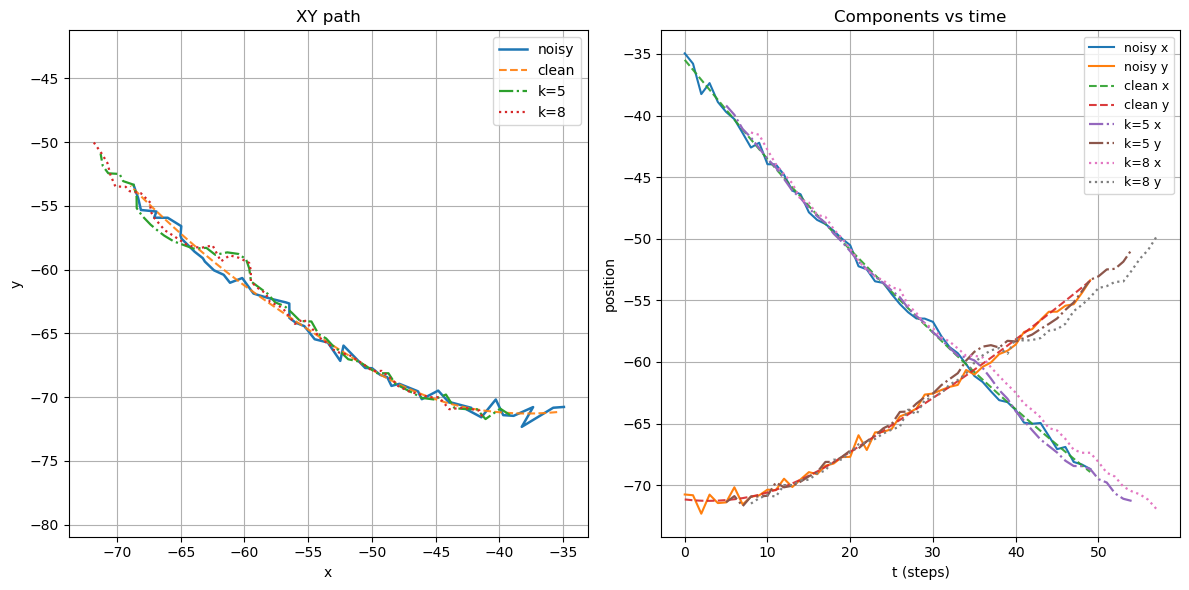

In [121]:
from src.visual.visual_tools import plot_trajectories_with_predictions_shifted

idx = 17
class_name = "AgileTargetErraticTurnsAndBursts"
print(f"Chronos nmse: {chronos_mse_per_trajectory[class_name][idx]}")
print(f"IMM nmse: {kf_mse_per_trajectory[class_name][idx]}")
chronos_traj = chronos_predictions_per_trajectory[class_name][idx]
imm_traj = kf_predictions_per_trajectory[class_name][idx]
noisy = full_data[class_name]["X"][idx]
real = full_data[class_name]["Y"][idx]
plot_trajectories_with_predictions_shifted(noisy[80:130], real[80:130], [(imm_traj[80:130], 5), (chronos_traj[80:130], 8)])
